# Google Advanced Data Analytics Project
The main aim is to build a machine learning model that can be used to determine whether a video contains a claim or whether it offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently using machine learning techniques to predict on a binary outcome variable.

The **purpose** of this model is to mitigate misinformation in videos on the TikTok platform.

The **goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".

This project has three parts:

## Business need and modeling objective
 
TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported—too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

## Modeling workflow and model selection process

Previous work with this data has revealed that there are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

- Split the data into train/validation/test sets (60/20/20)
- Fit models and tune hyperparameters on the training set
- Perform final model selection on the validation set
- Assess the champion model's performance on the test set

## Select an evaluation metric

To determine which evaluation metric might be best, consider how the model might be wrong. There are two possibilities for bad predictions:

- False positives: When the model predicts a video is a claim when in fact it is an opinion
- False negatives: When the model predicts a video is an opinion when in fact it is a claim

## Modeling design and target variable

The data dictionary shows that there is a column called claim_status. This is a binary value that indicates whether a video is a claim or an opinion. This will be the target variable. In other words, for each video, the model should predict whether the video is a claim or an opinion.

This is a classification task because the model is predicting a binary class.

![image](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)

# Task 1. Imports and data loading
Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
data = pd.read_csv('/kaggle/input/tiktok-dataset/tiktok_dataset.csv')
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


# Task 2: Examine data, summary info, and descriptive stats
Generate basic descriptive statistics about the dataset.


In [3]:
data.shape

(19382, 12)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


There are very few missing values relative to the number of samples in the dataset. Therefore, observations with missing values can be dropped.

In [5]:
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [6]:
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [7]:
data = data.dropna(axis = 0)

In [8]:
data.duplicated().sum()

0

 Tree-based models are robust to outliers, so there is no need to impute or drop any values based on where they fall in their distribution.

In [9]:
data['claim_status'].value_counts(normalize = True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced.

# Task 3. Feature engineering
Extract the length (character count) of each video_transcription_text and add this to the dataframe as a new column called text_length so that it can be used as a feature in the model.

In [13]:
data['text_length'] = data['video_transcription_text'].str.len()

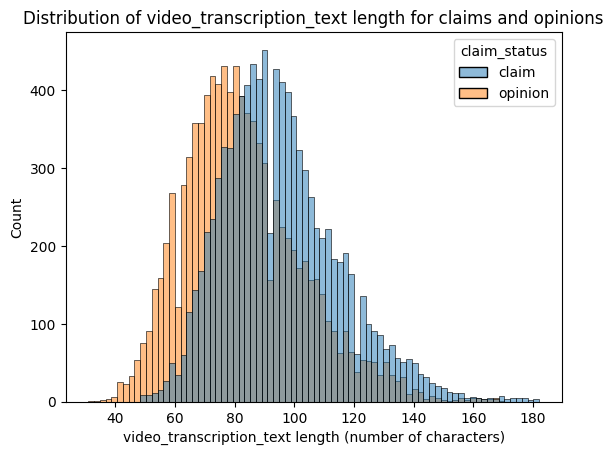

In [14]:
sns.histplot(data = data, x = 'text_length', hue = 'claim_status')
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

In [15]:
print(data['author_ban_status'].unique())
print(data['verified_status'].unique())

['under review' 'active' 'banned']
['not verified' 'verified']


Encode target and catgorical variables.

In [16]:
X = data.copy()
X = X.drop(['#', 'video_id'], axis=1)
X['author_ban_status']=X['author_ban_status'].replace({"under review":1, "active":2, 'banned':3})
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
X['verified_status'] = X['verified_status'].replace({'not verified': 0, 'verified': 1})
X.head()

,claim_status,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,59,someone shared with me that drone deliveries a...,0,1,343296.0,19425.0,241.0,1.0,0.0,97
1,1,32,someone shared with me that there are more mic...,0,2,140877.0,77355.0,19034.0,1161.0,684.0,107
2,1,31,someone shared with me that american industria...,0,2,902185.0,97690.0,2858.0,833.0,329.0,137
3,1,25,someone shared with me that the metro of st. p...,0,2,437506.0,239954.0,34812.0,1234.0,584.0,131
4,1,19,someone shared with me that the number of busi...,0,2,56167.0,34987.0,4110.0,547.0,152.0,128


# Task 4. Split the data
Assign target variable.

In this case, the target variable is claim_status.
0 represents an opinion
1 represents a claim

In [17]:
y = X['claim_status']

In [18]:
X = X.drop(['claim_status', 'video_transcription_text'],axis = 1)
X.head()

,video_duration_sec,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,59,0,1,343296.0,19425.0,241.0,1.0,0.0,97
1,32,0,2,140877.0,77355.0,19034.0,1161.0,684.0,107
2,31,0,2,902185.0,97690.0,2858.0,833.0,329.0,137
3,25,0,2,437506.0,239954.0,34812.0,1234.0,584.0,131
4,19,0,2,56167.0,34987.0,4110.0,547.0,152.0,128


# Task 5: Create train/validate/test sets
Split data into training and testing sets, 80/20.

In [19]:
x_tr, x_test, y_tr, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_tr,y_tr, test_size = 0.25, random_state = 42)

In [20]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((11450, 9), (11450,), (3817, 9), (3817,), (3817, 9), (3817,))

# Task 6. Build models
Build a random forest model
Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [21]:
rf = RandomForestClassifier(random_state = 42)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }
# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [22]:
%%time
rf_cv.fit(x_train, y_train)

CPU times: user 6min 34s, sys: 1.1 s, total: 6min 35s
Wall time: 6min 35s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'precision', 'accuracy', 'f1', 'recall'})

In [23]:
rf_cv.best_score_

0.9913766326500252

This model performs exceptionally well, with an average recall score of 0.995 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

In [24]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': 7,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

# Task 7. Evaluate models
Evaluate models against validation data.

In [25]:
y_pred = rf_cv.best_estimator_.predict(x_val)

Create a confusion matrix to visualize the results of the classification model.

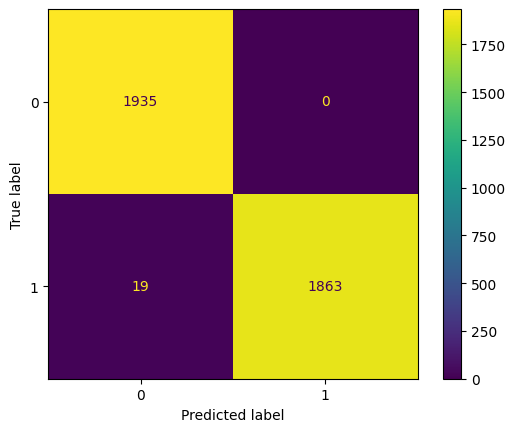

In [26]:
log_cm = confusion_matrix(y_val,y_pred)
log_disp = ConfusionMatrixDisplay(confusion_matrix = log_cm, display_labels = None)
log_disp.plot()
plt.show()

The upper-left quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.

The lower-left quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.

The lower-right quadrant displays the number of true positives: the number of claims that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

As the above confusion matrix shows, this model does not produce any false negatives.

In [27]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1935
       claim       1.00      0.99      0.99      1882

    accuracy                           1.00      3817
   macro avg       1.00      0.99      1.00      3817
weighted avg       1.00      1.00      1.00      3817



The classification report above shows that the random forest model scores were nearly perfect. The confusion matrix indicates that there were 10 misclassifications—five false postives and five false negatives

## Feature importances of champion model

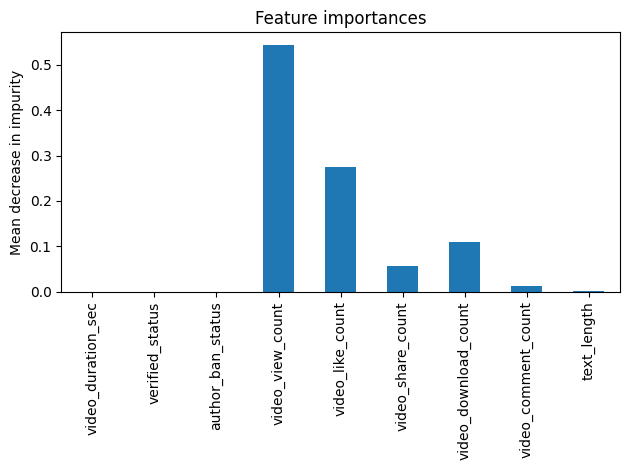

In [28]:
important_features= rf_cv.best_estimator_.feature_importances_
importances = pd.Series(important_features, index = x_test.columns)
fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
